In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### First prepare the json so that the rating is formatted better

In [2]:
with open('completed_perfumes.json', 'r', encoding='utf-8') as f:
    big_dic = json.load(f)


for idx, list_element in enumerate(big_dic):

    detailed_ratings = big_dic[idx]['detailed_ratings']

    for typ, rating_list in detailed_ratings.items():
        buf_dic = {}
        if rating_list is not None:
            for rating_element in rating_list:
                buf_dic[rating_element['r']] = rating_element['v']
            detailed_ratings[typ] = buf_dic
        else:
            detailed_ratings[typ] = None 


    big_dic[idx]['detailed_ratings'] = detailed_ratings

df = pd.json_normalize(big_dic)

In [3]:
df.info

<bound method DataFrame.info of                                                    name  \
0                     Remix Cologne Anniversary Edition   
1                                 Solarissimo - Levanzo   
2                                      A*Men Ultra Zest   
3                                     Acqua Nobile Rosa   
4                                        Minuit et Demi   
...                                                 ...   
8229                                                NaN   
8230                                Diamond Parfums XXL   
8231                    Canoe Dana 1996 Eau de Toilette   
8232                                 Queen of The Night   
8233  Dubai - Meydan The Spirit of Dubai 2015 Eau de...   

                       brand    year         collection  \
0                       4711  2017.0               None   
1                     Azzaro  2016.0               None   
2                     Mugler  2015.0               None   
3             Acqua di 

**Take a look at an example element**

In [4]:
df[df['name'] == 'Khamrah']

,name,brand,year,collection,flakon_designer,perfumer,top_notes,middle_notes,base_notes,all_notes,...,scent_types.Harzig,scent_types.Rauchig,scent_types.Erdig,scent_types.Animalisch,scent_types.Fougère,scent_types.Chypre,detailed_ratings.durability,detailed_ratings.sillage,detailed_ratings.bottle,detailed_ratings.scent
992,Khamrah,Lattafa / لطافة,2022.0,None,None,None,"[Zimt, Muskat, Bergamotte]","[Dattel, Praline, Mahonial®, Tuberose]","[geröstete Tonkabohne, Vanille, Amberholz, Sia...",None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Remove the arabic letters to avoid formatting issues**

In [5]:
# strip of arabic name to have it cleaner
df['brand'] = df['brand'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
df[df['name'] == 'Khamrah']

,name,brand,year,collection,flakon_designer,perfumer,top_notes,middle_notes,base_notes,all_notes,...,scent_types.Harzig,scent_types.Rauchig,scent_types.Erdig,scent_types.Animalisch,scent_types.Fougère,scent_types.Chypre,detailed_ratings.durability,detailed_ratings.sillage,detailed_ratings.bottle,detailed_ratings.scent
992,Khamrah,Lattafa,2022.0,None,None,None,"[Zimt, Muskat, Bergamotte]","[Dattel, Praline, Mahonial®, Tuberose]","[geröstete Tonkabohne, Vanille, Amberholz, Sia...",None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Set the nonexisting scenttypes to 0**

In [6]:
df.loc[:, df.filter(like='scent_types.').columns] = df.filter(like='scent_types.').fillna(0)

**remove some unnecessary parts in the column names**

In [7]:
df = df.drop(df.filter(regex='^scent_strength').columns, axis=1)

df.columns = df.columns.str.replace(r'^[^.]+\.', '', regex=True)

pd.set_option('display.max_columns', None)  # Show all columns
print(df.columns)

Index(['name', 'brand', 'year', 'collection', 'flakon_designer', 'perfumer',
       'top_notes', 'middle_notes', 'base_notes', 'all_notes',
       ...
       'Harzig', 'Rauchig', 'Erdig', 'Animalisch', 'Fougère', 'Chypre',
       'durability', 'sillage', 'bottle', 'scent'],
      dtype='object', length=116)


**map all the top head and base notes to the column with all notes**

In [8]:
df["all_notes"] = df.apply(lambda row: 
    (row["top_notes"] or []) + (row["middle_notes"] or []) + (row["base_notes"] or []), axis=1
)

In [9]:
df[(df['all_notes'].apply(lambda x: 'Meeresbrise' in x if x is not None else False))] \
   [df['Duft.rating'] > 7.5].head()

/var/folders/lq/blpghcxd0b9cm2tsrvlqq9g40000gn/T/ipykernel_83236/961457575.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[(df['all_notes'].apply(lambda x: 'Meeresbrise' in x if x is not None else False))] \


,name,brand,year,collection,flakon_designer,perfumer,top_notes,middle_notes,base_notes,all_notes,url,Duft.rating,Duft.number_of_ratings,Haltbarkeit.rating,Haltbarkeit.number_of_ratings,Sillage.rating,Sillage.number_of_ratings,Flakon.rating,Flakon.number_of_ratings,Preis-Leistungs-Verhältnis.rating,Preis-Leistungs-Verhältnis.number_of_ratings,scent.0,scent.1,scent.2,scent.3,scent.4,scent.5,scent.6,scent.7,scent.8,scent.9,scent.10,durability.0,durability.1,durability.2,durability.3,durability.4,durability.5,durability.6,durability.7,durability.8,durability.9,durability.10,sillage.0,sillage.1,sillage.2,sillage.3,sillage.4,sillage.5,sillage.6,sillage.7,sillage.8,sillage.9,sillage.10,bottle.0,bottle.1,bottle.2,bottle.3,bottle.4,bottle.5,bottle.6,bottle.7,bottle.8,bottle.9,bottle.10,pricing.0,pricing.1,pricing.2,pricing.3,pricing.4,pricing.5,pricing.6,pricing.7,pricing.8,pricing.9,pricing.10,Zitrus,Würzig,Grün,Fruchtig,Frisch,Blumig,Herren,Damen,Klassisch,Modern,Winter,Herbst,Sommer,Frühling,Täglich,Sport,Freizeit,Ausgehen,Arbeit,Abend,pricing,Synthetisch,Süß,Holzig,Aquatisch,Gourmand,Pudrig,Orientalisch,Cremig,Ledrig,Harzig,Rauchig,Erdig,Animalisch,Fougère,Chypre,durability,sillage,bottle,scent
108,Costa Azzurra Acqua,Tom Ford,2019.0,None,None,Yann Vasnier,"[Meeresbrise, Wacholder, Zypresse, Myrte]","[Kiefernnadel, Kiefernzapfen, Zitrone]","[Mastixharz, Zistrose Absolue]","[Meeresbrise, Wacholder, Zypresse, Myrte, Kief...",https://www.parfumo.de/Parfums/Tom_Ford/Costa_...,7.6,218.0,6.5,200.0,6.2,201.0,8.4,228.0,6.1,107.0,1.0,1.0,0.0,1.0,2.0,7.0,31.0,77.0,58.0,34.0,6.0,1.0,0.0,0.0,2.0,3.0,24.0,72.0,74.0,17.0,4.0,3.0,1.0,1.0,0.0,1.0,5.0,27.0,90.0,60.0,12.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0,30.0,85.0,55.0,47.0,0.0,0.0,3.0,4.0,6.0,18.0,35.0,26.0,9.0,3.0,3.0,18.73,11.61,6.74,0.0,22.10,0.00,71.28,28.72,40.91,59.09,5.59,11.89,46.15,36.36,22.75,17.65,23.92,8.24,19.61,7.84,NaN,5.62,0.00,11.99,23.22,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
237,White Tea Elizabeth Arden 2022 Eau de Parfum,Elizabeth Arden,2022.0,None,None,Rodrigo Flores-Roux,"[italienische Mandarine, Muskatellersalbei, Me...","[weißer Tee, Jasmin, Mate Absolue, Rosenwasser]","[Amberholz, Moschus, venezolanische Tonkabohne]","[italienische Mandarine, Muskatellersalbei, Me...",https://www.parfumo.de/Parfums/Elizabeth_Arden...,8.1,60.0,7.0,55.0,6.3,52.0,7.8,64.0,8.6,50.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,13.0,18.0,15.0,6.0,0.0,0.0,0.0,0.0,2.0,4.0,10.0,19.0,14.0,6.0,0.0,0.0,0.0,0.0,2.0,2.0,9.0,14.0,17.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0,12.0,25.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,10.0,14.0,16.0,8.14,0.00,11.63,0.0,26.74,23.26,21.21,78.79,57.69,42.31,14.29,22.62,32.14,30.95,27.84,10.31,25.77,4.12,23.71,8.25,NaN,0.00,0.00,9.30,0.00,0.0,6.98,0.0,13.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
591,Naki,pernoire,2023.0,Anima Collection,None,Andreas Wilhelm,"[Pfirsich, Aldehyde, Mandelblüte, Passionsfrucht]","[Feigenblatt, weiße Blüten, Sandelholz]","[weißer Moschus, Meeresbrise, Osmanthus, Vanille]","[Pfirsich, Aldehyde, Mandelblüte, Passionsfruc...",https://www.parfumo.de/Parfums/pernoire/naki,7.6,168.0,7.8,143.0,7.4,144.0,8.1,135.0,6.6,115.0,0.0,0.0,2.0,3.0,2.0,6.0,26.0,45.0,50.0,20.0,14.0,0.0,0.0,0.0,1.0,1.0,5.0,4.0,30.0,70.0,24.0,8.0,0.0,0.0,1.0,0.0,2.0,5.0,9.0,56.0,54.0,13.0,4.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,23.0,66.0,19.0,18.0,0.0,2.0,1.0,1.0,6.0,13.0,22.0,38.0,24.0,4.0,4.0,0.00,0.00,7.03,22.7,21.62,14.05,41.79,58.21,23.40,76.60,6.60,13.21,38.68,41.51,18.75,5.56,26.39,16.67,18.75,13.89,NaN,8.11,15.68,0.00,0.00,0.0,0.00,0.0,10.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1808,White Tea Elizabeth Arden 2017 Eau de Toilette,Elizabeth Arden,2017.0,None,None,Rodrigo Flores-Roux,"[italienische Mandarine, Meeresbrise, Muskatel...","[weißer Tee, weiße Iris, paraguayischer Mate A...","[Ambermax®, Ambrettesamen Absolue, indische Hö...","[italienische Mandarine, Meeresbrise, Muskatel...",https://www.parfumo.de/Parfums/Elizabeth_Arden...,7.6,338.0,6.3,304.0,5.

In [10]:
for col in df.columns:
    print(col)


name
brand
year
collection
flakon_designer
perfumer
top_notes
middle_notes
base_notes
all_notes
url
Duft.rating
Duft.number_of_ratings
Haltbarkeit.rating
Haltbarkeit.number_of_ratings
Sillage.rating
Sillage.number_of_ratings
Flakon.rating
Flakon.number_of_ratings
Preis-Leistungs-Verhältnis.rating
Preis-Leistungs-Verhältnis.number_of_ratings
scent.0
scent.1
scent.2
scent.3
scent.4
scent.5
scent.6
scent.7
scent.8
scent.9
scent.10
durability.0
durability.1
durability.2
durability.3
durability.4
durability.5
durability.6
durability.7
durability.8
durability.9
durability.10
sillage.0
sillage.1
sillage.2
sillage.3
sillage.4
sillage.5
sillage.6
sillage.7
sillage.8
sillage.9
sillage.10
bottle.0
bottle.1
bottle.2
bottle.3
bottle.4
bottle.5
bottle.6
bottle.7
bottle.8
bottle.9
bottle.10
pricing.0
pricing.1
pricing.2
pricing.3
pricing.4
pricing.5
pricing.6
pricing.7
pricing.8
pricing.9
pricing.10
Zitrus
Würzig
Grün
Fruchtig
Frisch
Blumig
Herren
Damen
Klassisch
Modern
Winter
Herbst
Sommer
Frühling


**Save to excel**

In [11]:
df.to_excel("perfumes.xlsx", sheet_name="Sheet1", index=False)


In [12]:
KRITERIUM = 'Zitrus'
ANZ_DUFT_RATINGS = 100
crit =  KRITERIUM 
duft = 'Duft' + '.rating'
duft_ratings = 'Duft' + '.number_of_ratings'
haltbarkeit = 'Haltbarkeit' + '.rating'
sillage = 'Sillage' + '.rating'

filtered_df = df[
    (df[duft] > 7.5) & 
    (df[haltbarkeit] > 7.5) & 
    (df[sillage] > 7.5) & 
    (df[duft_ratings] > ANZ_DUFT_RATINGS)
    ].sort_values(by=crit, ascending=False)

# Select specific columns and show the first 10 rows
result = filtered_df[['name', 'brand', crit, duft, haltbarkeit, sillage]].head(20)

# Print result
pd.set_option('display.width', 250)  # Set the max width (adjust as needed)
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed
print(result)

                                             name              brand  Zitrus  Duft.rating  Haltbarkeit.rating  Sillage.rating
938                                   Imagination      Louis Vuitton   27.26          8.9                 7.8             7.6
2291                                    Bergamask        Orto Parisi   26.90          7.8                 8.9             8.4
5642                                          NaN                NaN   26.51          8.1                 8.4             8.0
8082                    Portfolio - Neroli Canvas        Al Haramain   25.76          8.2                 8.2             7.6
2980                                       Ginger  Widian  AJ Arabia   25.00          9.0                 8.1             7.6
169                                        Nero70            XerJoff   23.64          8.0                 8.0             7.6
6888                             Le Gemme - Tygar            Bvlgari   23.26          8.4                 7.8         

---

#### Let's test out some plots

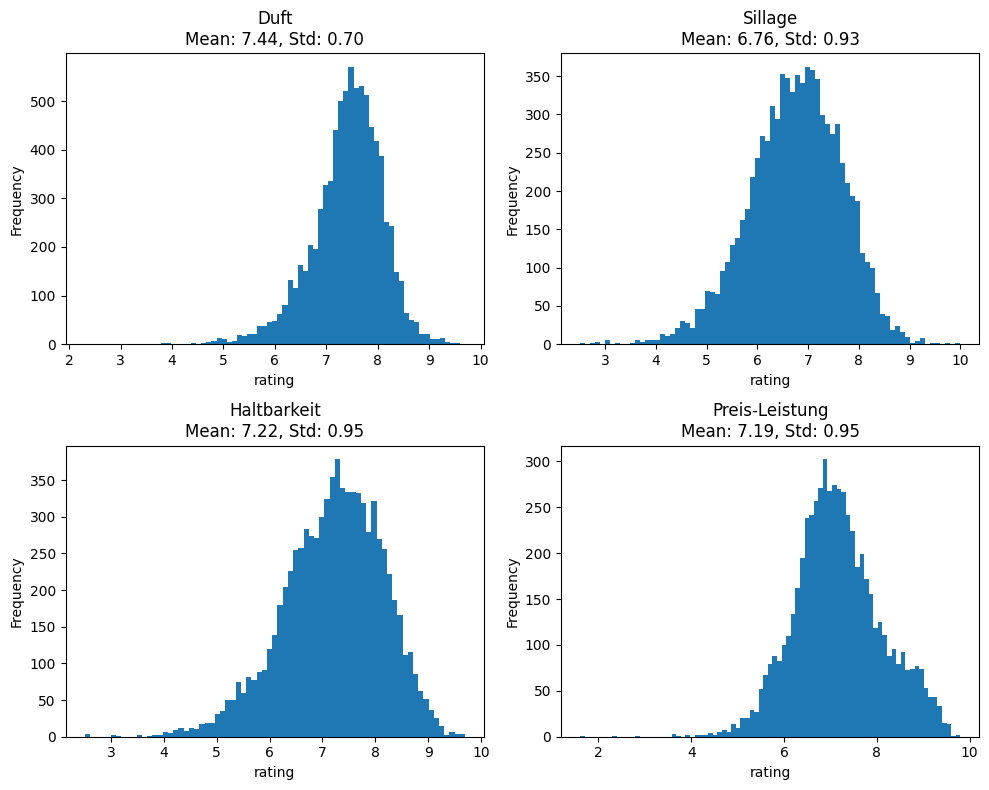

In [13]:
col_data = {
    "Duft": np.array(df['Duft.rating'].dropna()),
    "Sillage": np.array(df['Sillage.rating'].dropna()),
    "Haltbarkeit": np.array(df['Haltbarkeit.rating'].dropna()),
    "Preis-Leistung": np.array(df['Preis-Leistungs-Verhältnis.rating'].dropna())
}
scent_hist = np.array(df['Duft.rating'].dropna())
scent_mean = scent_hist.mean()
scent_std = scent_hist.std()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

def get_bins(array):
    span = array.max() - array.min()
    bins = int(span*10) + 1
    return bins

# Plot the histograms in each of the 4 subplots
# Iterate over the dictionary and plot different entries
for i, (title, data) in enumerate(col_data.items()):
    ax = axes[i]
    ax.hist(data, bins=get_bins(data)) #have as many bins as there are different ratings
    ax.set_title(f'{title}\nMean: {data.mean():.2f}, Std: {data.std():.2f}')
    ax.set_xlabel(f'rating')
    ax.set_ylabel('Frequency')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

#### Let's take a look at the performance of some perfumers

In [14]:
filtered_scores = df.loc[df['perfumer'] == 'Anne Flipo', 'Duft.rating']
print(len(filtered_scores))

64


##### Brands

Brand Counts: {'Guerlain': 139, 'Zara': 130, 'Giorgio Armani': 95, 'Dior': 73, 'Tom Ford': 71, 'Yves Saint Laurent': 63, 'Jil Sander': 60, 'XerJoff': 60, 'Amouage': 59, 'Hugo Boss': 58, 'Mugler': 55, 'Calvin Klein': 54, 'Dolce  Gabbana': 53, 'Lancme': 53, 'Rabanne': 51, 'Yves Rocher': 45, 'Givenchy': 45, 'Bvlgari': 44, 'Jean Paul Gaultier': 44, 'Issey Miyake': 44, 'Penhaligons': 42, 'Gucci': 41, 'Herms': 41, 'Jo Malone': 40, 'Kilian': 39, 'Roja Parfums': 38, 'Prada': 37, 'Chanel': 35, 'Kenzo': 35, 'M Micallef': 33, 'Maison Francis Kurkdjian': 33, 'Montale': 32, 'Davidoff': 31, 'Acqua di Parma': 30, 'Narciso Rodriguez': 29, 'Louis Vuitton': 28, 'Carolina Herrera': 28, 'Burberry': 28, 'Areej Le Dor': 28, 'Valentino': 27, 'Azzaro': 27, 'Zoologist': 27, 'Serge Lutens': 26, 'Aaron Terence Hughes': 26, '4711': 26, 'Cartier': 25, 'Marc Jacobs': 25, 'Parfums de Marly': 25, 'Chlo': 25, 'Otto Kern': 24, 'Lacoste': 24, 'Rituals': 24, 'Diptyque': 23, 'The Dua Brand  Dua Fragrances': 23, 'Escada': 

Text(0.5, 1.0, 'Perfume Count by Brand')

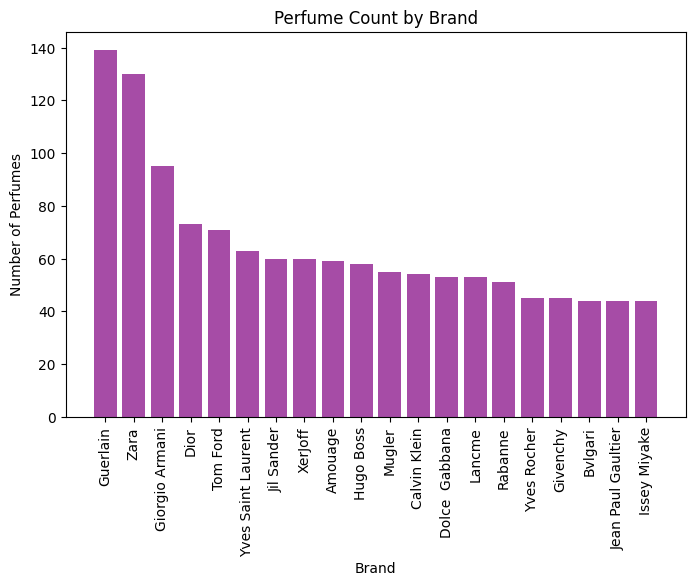

In [15]:
brand_counts = df['brand'].value_counts().to_dict()
# Get the top 4 perfumers
top_4_brands = dict(sorted(brand_counts.items(), key=lambda x: x[1], reverse=True)[:4])

print("Brand Counts:", brand_counts)
print("Top 4 Brands:", top_4_brands)

brand = list(brand_counts.keys())
b_counts = list(brand_counts.values())

top = 20
# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(brand[:top], b_counts[:top], color='purple', alpha=0.7)

# Labels and title
plt.xlabel('Brand')
plt.ylabel('Number of Perfumes')
plt.xticks(rotation=90)

plt.title('Perfume Count by Brand')

In [16]:
df.loc[df['brand'] == 'Xerjoff', 'Duft.rating'].dropna()

Series([], Name: Duft.rating, dtype: float64)

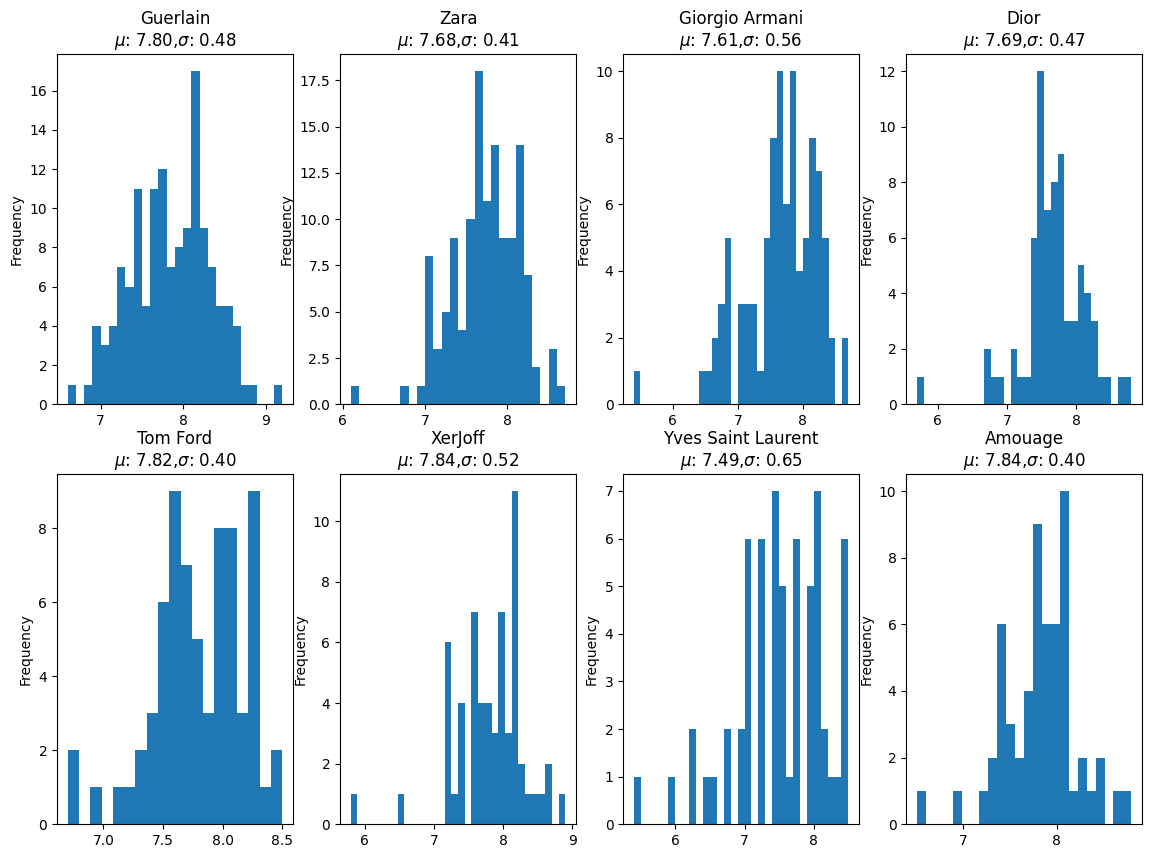

In [17]:
names = ['Guerlain', 'Zara', 'Giorgio Armani', 'Dior', 'Tom Ford', 'XerJoff', 'Yves Saint Laurent', 'Amouage']
col_data = {
    names[0]: np.array(df.loc[df['brand'] == names[0], 'Duft.rating'].dropna()),
    names[1]: np.array(df.loc[df['brand'] == names[1], 'Duft.rating'].dropna()),
    names[2]: np.array(df.loc[df['brand'] == names[2], 'Duft.rating'].dropna()),
    names[3]: np.array(df.loc[df['brand'] == names[3], 'Duft.rating'].dropna()),
    names[4]: np.array(df.loc[df['brand'] == names[4], 'Duft.rating'].dropna()),
    names[5]: np.array(df.loc[df['brand'] == names[5], 'Duft.rating'].dropna()),
    names[6]: np.array(df.loc[df['brand'] == names[6], 'Duft.rating'].dropna()),
    names[7]: np.array(df.loc[df['brand'] == names[7], 'Duft.rating'].dropna()),
}
scent_hist = np.array(df['Duft.rating'].dropna())
scent_mean = scent_hist.mean()
scent_std = scent_hist.std()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(14, 10))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

def get_bins(array):
    span = array.max() - array.min()
    bins = int(span*10) + 1
    return bins

# Plot the histograms in each of the 4 subplots
# Iterate over the dictionary and plot different entries
for i, (title, data) in enumerate(col_data.items()):
    ax = axes[i]
    ax.hist(data, bins=get_bins(data)) #have as many bins as there are different ratings
    ax.set_title(f'{title}\n' + r'$\mu$' + f': {data.mean():.2f},' r'$\sigma$' + f': {data.std():.2f}')
    # ax.set_xlabel(f'rating')
    ax.set_ylabel('Frequency')
# Adjust layout for better

# Show the plots
plt.show()

##### Perfumers

Perfumer Counts: {'Alberto Morillas': 157, 'Jérôme Epinette': 92, 'Thierry Wasser': 91, 'Francis Kurkdjian': 88, 'Dominique Ropion': 82, 'Nathalie Lorson': 81, 'François Demachy': 79, 'Quentin Bisch': 71, 'Olivier Cresp': 67, 'Anne Flipo': 64, 'Marie Salamagne': 64, 'Sonia Constant': 63, 'Michel Almairac': 58, 'Fabrice Pellegrin': 56, 'Daniela Andrier': 56, 'Jacques Cavallier-Belletrud': 56, 'Aurélien Guichard': 50, 'Christian Carbonnel a.k.a. Chris Maurice': 50, 'Bertrand Duchaufour': 48, 'Olivier Polge': 48, 'Christine Nagel': 47, 'Christophe Raynaud': 46, 'Delphine Jelk': 42, 'Louise Turner': 42, 'Aliénor Massenet': 41, 'Daphné Bugey': 41, 'Prin Lomros': 40, 'Rodrigo Flores-Roux': 40, 'Antoine Maisondieu': 39, 'Roja Dove': 38, 'Julie Massé': 37, 'Julien Rasquinet': 37, 'Honorine Blanc': 37, 'Carlos Benaïm': 37, 'Sophie Labbé': 36, 'Jordi Fernández': 34, 'Olivier Pescheux': 33, 'Luca Maffei': 33, 'Paolo Terenzi': 32, 'Jean-Claude Ellena': 31, 'Annick Ménardo': 31, 'Véronique Nyberg':

Text(0.5, 1.0, 'Perfume Count by Perfumer')

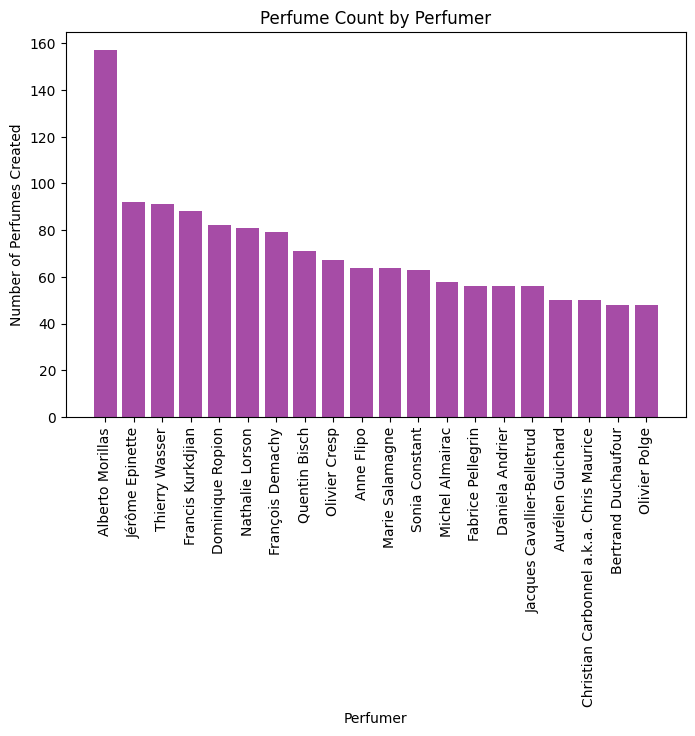

In [18]:
perfumer_counts = df['perfumer'].value_counts().to_dict()
# Get the top 4 perfumers
top_4_perfumers = dict(sorted(perfumer_counts.items(), key=lambda x: x[1], reverse=True)[:4])

print("Perfumer Counts:", perfumer_counts)
print("Top 4 Perfumers:", top_4_perfumers)

perfumers = list(perfumer_counts.keys())
counts = list(perfumer_counts.values())

top = 20
# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(perfumers[:top], counts[:top], color='purple', alpha=0.7)

# Labels and title
plt.xlabel('Perfumer')
plt.ylabel('Number of Perfumes Created')
plt.xticks(rotation=90)

plt.title('Perfume Count by Perfumer')

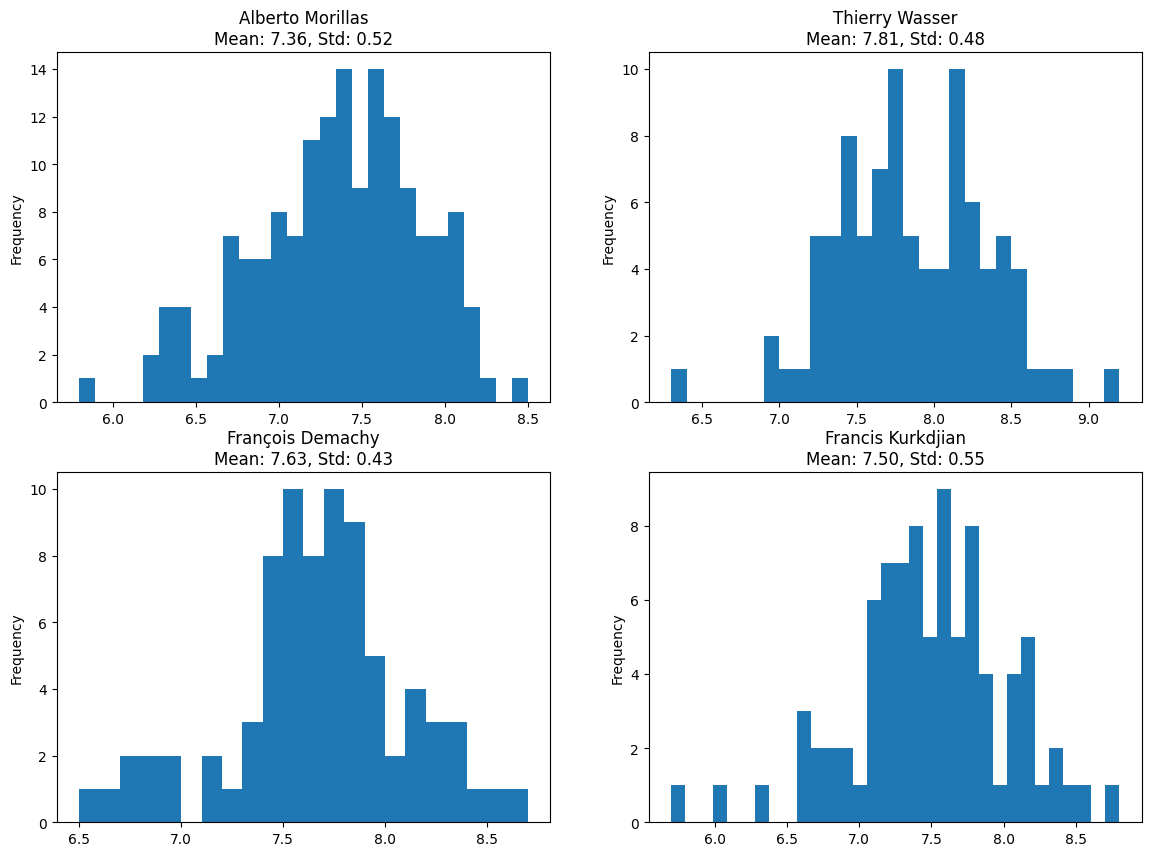

In [19]:
names = ['Alberto Morillas', 'Thierry Wasser', 'François Demachy', 'Francis Kurkdjian']
col_data = {
    names[0]: np.array(df.loc[df['perfumer'] == names[0], 'Duft.rating'].dropna()),
    names[1]: np.array(df.loc[df['perfumer'] == names[1], 'Duft.rating'].dropna()),
    names[2]: np.array(df.loc[df['perfumer'] == names[2], 'Duft.rating'].dropna()),
    names[3]: np.array(df.loc[df['perfumer'] == names[3], 'Duft.rating'].dropna())
}
scent_hist = np.array(df['Duft.rating'].dropna())
scent_mean = scent_hist.mean()
scent_std = scent_hist.std()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

def get_bins(array):
    span = array.max() - array.min()
    bins = int(span*10) + 1
    return bins

# Plot the histograms in each of the 4 subplots
# Iterate over the dictionary and plot different entries
for i, (title, data) in enumerate(col_data.items()):
    ax = axes[i]
    ax.hist(data, bins=get_bins(data)) #have as many bins as there are different ratings
    ax.set_title(f'{title}\nMean: {data.mean():.2f}, Std: {data.std():.2f}')
    # ax.set_xlabel(f'rating')
    ax.set_ylabel('Frequency')
# Adjust layout for better

# Show the plots
plt.show()

#### Now take a look at the scent types

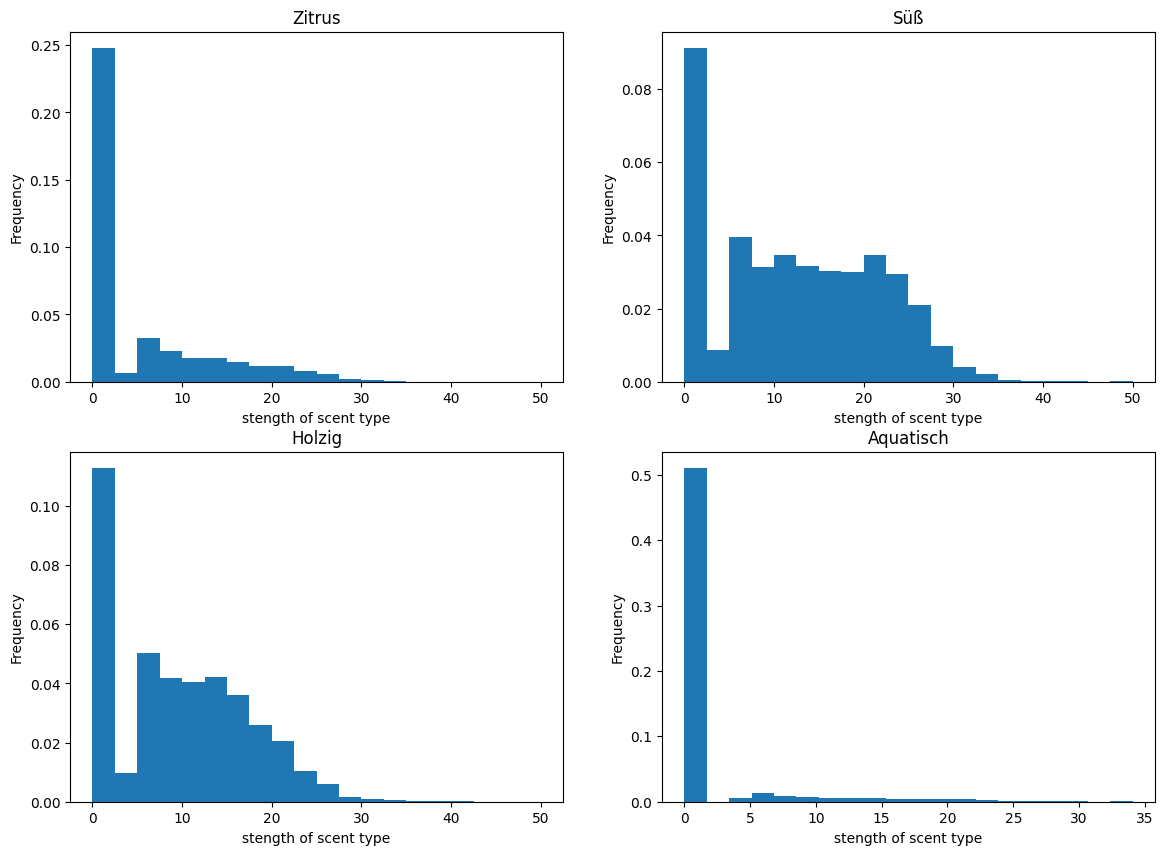

In [20]:
scent_type_names = ['Zitrus', 'Süß', 'Holzig', 'Aquatisch']

col_data = {
    scent_type_names[0]: df[scent_type_names[0]],
    scent_type_names[1]: df[scent_type_names[1]],
    scent_type_names[2]: df[scent_type_names[2]],
    scent_type_names[3]: df[scent_type_names[3]]
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

def get_bins(array):
    span = array.max() - array.min()
    bins = int(span*10) + 1
    return bins

for i, (title, data) in enumerate(col_data.items()):
    ax = axes[i]
    # ax.hist(data, bins=get_bins(data)) #have as many bins as there are different ratings
    ax.hist(data, bins=20, density=True) #have as many bins as there are different ratings
    ax.set_title(f'{title}')
    ax.set_xlabel(f'stength of scent type')
    ax.set_ylabel('Frequency')

# Show the plots
plt.show()

### Now we can think about how to choose the right features and what to analyize

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

df['all_notes'] = df['all_notes'].apply(lambda x: x if isinstance(x, list) else [])

# Apply MultiLabelBinarizer to each column and create new DataFrames
notes_encoded = pd.DataFrame(mlb.fit_transform(df['all_notes']), columns=mlb.classes_, index=df.index)

# Merge with the original DataFrame
df_encoded = pd.concat([df, notes_encoded], axis=1)

In [23]:
df_encoded[(df_encoded['Bergamotte']==1) & (df_encoded['Rose']==1)].head()

name             brand    year collection flakon_designer               perfumer                                          top_notes                                       middle_notes  \
51                                Amour   Pierre de Velay  2021.0       None            None              Roja Dove                       [Bergamotte, Kaffernlimette]  [Heliotrop, Ylang-Ylang, Rose, Veilchen, Jasmi...   
123                           Woman III        Jil Sander  2012.0       None            None                   None              [Bergamotte, Bitterorange, Koriander]                                [Gartennelke, Rose]   
125       Aqua Allegoria Granada Salvia          Guerlain  2020.0       None            None         Thierry Wasser  [Granatapfel, Zitrone, Bergamotte, Schwarze Jo...                                     [Salbei, Rose]   
133  Guilty Elixir de Parfum pour Femme             Gucci  2023.0       None            None  Nathalie Gracia-Cetto                    [Veilchen, Mandora, Bergamotte]                       [Blauregen, Rose, Osmanthus]   
196                              Poésie  Frdric Haldimann  2013.0       None            None     Frédéric Haldimann    [Bergamotte, Orangenblüte, Osmanthus, Pfirsich]                [Geißblatt, Jasmin, Rose, Tuberose]   

                                            base_notes                                          all_notes                                                url  Duft.rating  Duft.number_of_ratings  Haltbarkeit.rating  Haltbarkeit.number_of_ratings  \
51   [Zistrose, Benzoe, Ingwer, Labdanum, Moos, Mos...  [Bergamotte, Kaffernlimette, Heliotrop, Ylang-...  https://www.parfumo.de/Parfums/Pierre_de_Velay...          8.3                    79.0                 8.5                           72.0   
123                                        [Patchouli]  [Bergamotte, Bitterorange, Koriander, Gartenne...  https://www.parfumo.de/Parfums/Jil_Sander/Woma...          7.2                    46.0                 7.3                           31.0   
125                  [weißer Moschus, Moos, Patchouli]  [Granatapfel, Zitrone, Bergamotte, Schwarze Jo...  https://www.parfumo.de/Parfums/Guerlain/aqua-a...          7.9                   319.0                 6.5                          272.0   
133           [Patchouli, Tonkabohne, Vanille Absolue]  [Veilchen, Mandora, Bergamotte, Blauregen, Ros...  https://www.parfumo.de/Parfums/Gucci/guilty-el...          6.9                    65.0                 7.8                           55.0   
196  [Amber, Iris, Moschus, Patchouli, Sandelholz, ...  [Bergamotte, Orangenblüte, Osmanthus, Pfirsich...  https://www.parfumo.de/Parfums/Frederic_Haldim...          7.9                    25.0                 7.6                           19.0   

     Sillage.rating  Sillage.number_of_ratings  Flakon.rating  Flakon.number_of_ratings  Preis-Leistungs-Verhältnis.rating  Preis-Leistungs-Verhältnis.number_of_ratings  scent.0  scent.1  scent.2  scent.3  scent.4  scent.5  scent.6  scent.7  \
51              7.8                       71.0            8.4                      70.0                                5.8                                          46.0      0.0      0.0      0.0      1.0      0.0      1.0      5.0     10.0   
123             7.0                       31.0            7.0                      42.0                                NaN                                           NaN      0.0      0.0      1.0      0.0      2.0      2.0      7.0     13.0   
125             6.3                      269.0            8.6                     261.0                                7.2                                         138.0      0.0      1.0      0.0      1.0      0.0      6.0     32.0     82.0   
133             7.4                       54.0            7.0                      55.0                                6.2                                          40.0      0.0      1.0      1.0      3.0      2.0      8.0     12.0     14.0   

In [24]:
# let's get some correlations between the ingredients and the scent type

correlation = df_encoded['Bergamotte'].corr(df_encoded['Zitrus'])
print(correlation)

0.12415018609000116


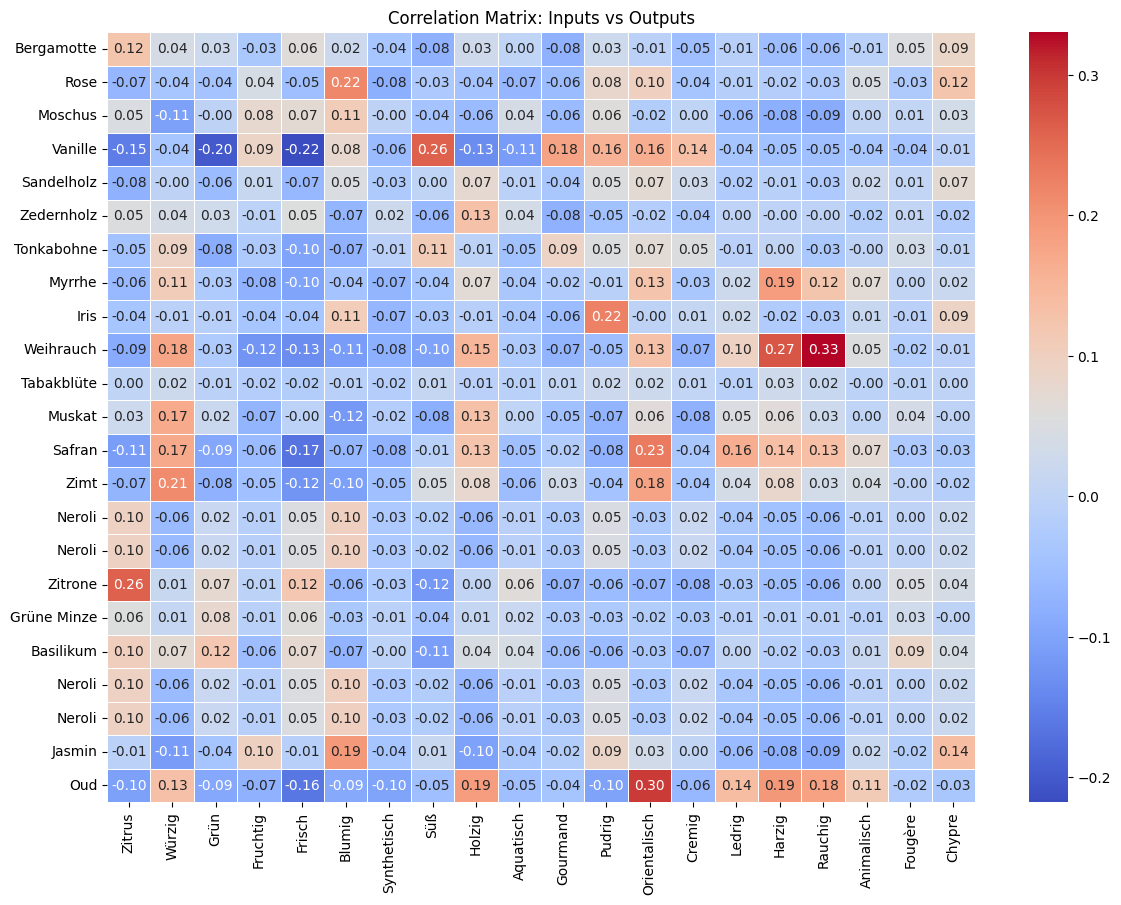

In [25]:
input_cols = ["Bergamotte", "Rose", "Moschus", "Vanille", "Sandelholz", "Zedernholz", "Tonkabohne", "Myrrhe", "Iris", "Weihrauch", "Tabakblüte", "Muskat", "Safran", "Zimt", "Neroli", "Zitrone", "Grüne Minze", "Basilikum", "Neroli", "Jasmin", "Oud"]
output_cols = ["Zitrus", "Würzig", "Grün", "Fruchtig", "Frisch", "Blumig", "Synthetisch", "Süß", "Holzig", "Aquatisch", "Gourmand", "Pudrig", "Orientalisch", "Cremig", "Ledrig", "Harzig", "Rauchig", "Animalisch", "Fougère", "Chypre"]

# Compute correlations between inputs & outputs
correlation_matrix = df_encoded[input_cols + output_cols].corr()

# Extract correlations between inputs and outputs
correlation_matrix = correlation_matrix.loc[input_cols, output_cols]

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix: Inputs vs Outputs")
plt.show()

In [26]:
output_cols = ["Zitrus", "Würzig", "Grün", "Fruchtig", "Frisch", "Blumig", "Synthetisch", "Süß", "Holzig", "Aquatisch", "Gourmand", "Pudrig", "Orientalisch", "Cremig", "Ledrig", "Harzig", "Rauchig", "Animalisch", "Fougère", "Chypre"]


In [27]:
best_inputs = {}
for output in output_cols:
    correlation_matrix = notes_encoded.corrwith(df[output])
    best_input = correlation_matrix.abs().idxmax()
    best_inputs[output] = (best_input, correlation_matrix[best_input])

# Print results
for output, (best_input, corr) in best_inputs.items():
    print(f"Best input for {output}: {best_input} (Correlation: {corr:.2f})")

Best input for Zitrus: Zitrone (Correlation: 0.26)
Best input for Würzig: Kardamom (Correlation: 0.22)
Best input for Grün: Vanille (Correlation: -0.20)
Best input for Fruchtig: Himbeere (Correlation: 0.22)
Best input for Frisch: Vanille (Correlation: -0.22)
Best input for Blumig: Rose (Correlation: 0.22)
Best input for Synthetisch: Oud (Correlation: -0.10)
Best input for Süß: Vanille (Correlation: 0.26)
Best input for Holzig: Oud (Correlation: 0.19)
Best input for Aquatisch: maritime Noten (Correlation: 0.31)
Best input for Gourmand: Karamell (Correlation: 0.26)
Best input for Pudrig: Iris (Correlation: 0.22)
Best input for Orientalisch: Oud (Correlation: 0.30)
Best input for Cremig: Vanille (Correlation: 0.14)
Best input for Ledrig: Leder (Correlation: 0.49)
Best input for Harzig: Weihrauch (Correlation: 0.27)
Best input for Rauchig: Weihrauch (Correlation: 0.33)
Best input for Animalisch: Zibet (Correlation: 0.31)
Best input for Fougère: Lavendel (Correlation: 0.17)
Best input for C

In [28]:
print(notes_encoded.columns)

Index(['Abelmoschus', 'Abend-Levkoje', 'Absinth', 'Ackerwinde', 'Adesmia boronioides', 'Adlerholzharz', 'Afrikanischer Rosmarin', 'Agave', 'Ahorn', 'Ahornsirup',
       ...
       'ägyptisches Labdanum', 'ägyptisches Neroli', 'ägyptisches Rosengeranienblatt', 'ägyptisches Veilchen', 'ägyptisches Veilchenblatt', 'ägyptisches Veilchenblatt Absolue', 'äthiopische Myrrhe', 'äthiopischer Kaffee Absolue',
       'äthiopischer Weihrauch', 'äthiopischer Zibet'],
      dtype='object', length=2603)


In [29]:
output_cols = ["Duft.rating", "Haltbarkeit.rating", "Sillage.rating"]
best_inputs = {}
for output in output_cols:
    correlation_matrix = notes_encoded.corrwith(df[output])
    best_input = correlation_matrix.abs().idxmax()
    best_inputs[output] = (best_input, correlation_matrix[best_input])

# Print results
for output, (best_input, corr) in best_inputs.items():
    print(f"Best input for {output}: {best_input} (Correlation: {corr:.2f})")

/Users/hamzaimamovic/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hamzaimamovic/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/hamzaimamovic/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hamzaimamovic/Library/Python/3.12/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Best input for Duft.rating: Oud (Correlation: 0.10)
Best input for Haltbarkeit.rating: Oud (Correlation: 0.19)
Best input for Sillage.rating: Oud (Correlation: 0.20)


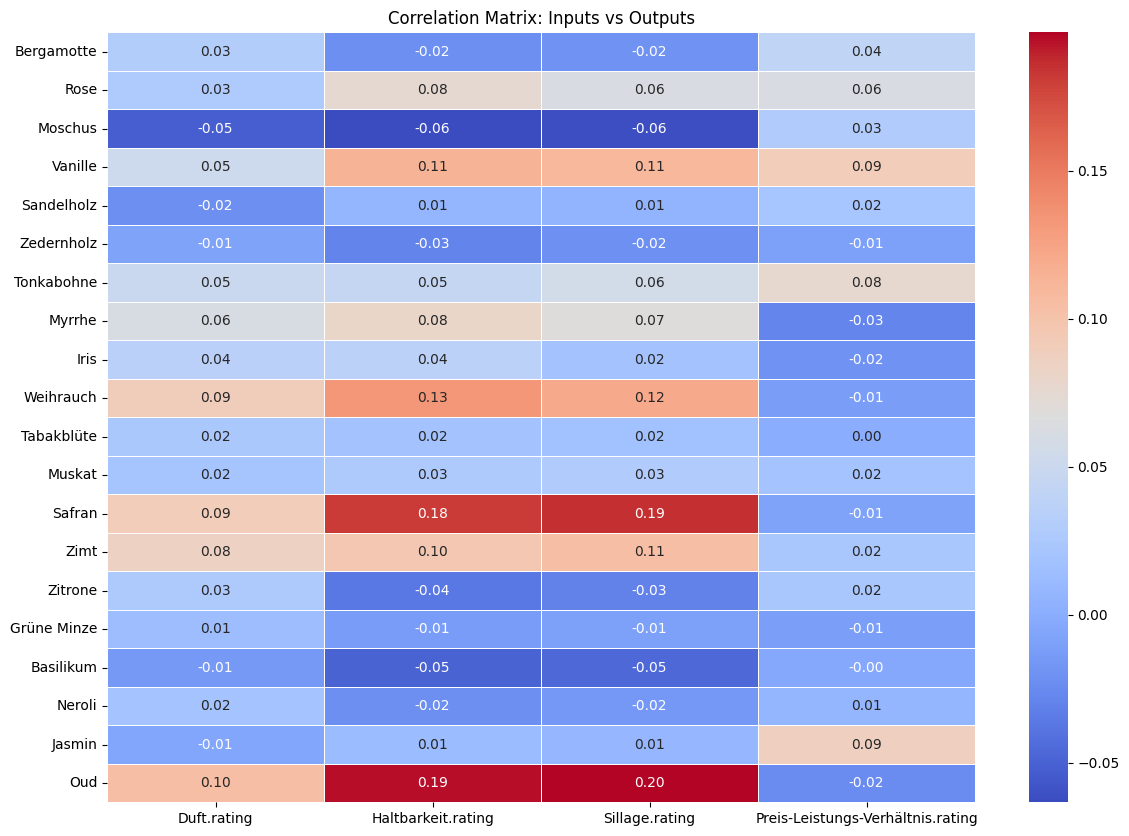

In [30]:
input_cols = ["Bergamotte", "Rose", "Moschus", "Vanille", "Sandelholz", "Zedernholz", "Tonkabohne", "Myrrhe", "Iris", "Weihrauch", "Tabakblüte", "Muskat", "Safran", "Zimt", "Zitrone", "Grüne Minze", "Basilikum", "Neroli", "Jasmin", "Oud"]
output_cols = ["Duft.rating", "Haltbarkeit.rating", "Sillage.rating", "Preis-Leistungs-Verhältnis.rating"]
# Compute correlations between inputs & outputs
correlation_matrix = df_encoded[input_cols + output_cols].corr()

# Extract correlations between inputs and outputs
correlation_matrix = correlation_matrix.loc[input_cols, output_cols]

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix: Inputs vs Outputs")
plt.show()